In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim

## Saccades

We have inputs to an Artificial Neural Network like these:

In [2]:
input = torch.tensor([
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [1, 1, 1, 1, 1]
], dtype=torch.float)

They represent some geometric objects. In this case it's a line.

The receptive field in our ANN will be bigger than this input. Every input is randomly moved.

So next, we take the input and create K=5 displacements (moving the original tensor in receptive field by (x,y) offset).

In [3]:
K = 5
N = 15

In [4]:
def create_displaced_tensors(tensor, K, receptive_field_size=(15, 15)):
    """
    Creates K displacements of the input tensor by moving it within a larger receptive field.
    
    Parameters:
        tensor (torch.Tensor): The original input tensor of shape (5, 5).
        K (int): The number of displacements to create.
        receptive_field_size (tuple): The dimensions of the receptive field (height, width).
        
    Returns:
        batch of tensors: A tensor of K tensors with the original tensor displaced within the receptive field.
    """
    
    # Create a larger tensor filled with zeros (the receptive field)
    receptive_field_h, receptive_field_w = receptive_field_size
    displaced_tensors = torch.zeros(K, receptive_field_h, receptive_field_w, dtype=tensor.dtype)
    
    # Calculate padding size based on the receptive field dimensions
    input_h, input_w = tensor.shape
    padding_h = receptive_field_h - input_h
    padding_w = receptive_field_w - input_w
    
    for i in range(K):
        # Randomly choose top-left corner for placing the input tensor within the receptive field
        max_x_offset = padding_h
        max_y_offset = padding_w
        x_offset = random.randint(0, max_x_offset)
        y_offset = random.randint(0, max_y_offset)
        
        # Place the input tensor within the receptive field at the chosen offset
        displaced_tensors[i, x_offset:x_offset + input_h, y_offset:y_offset + input_w] = tensor

    return displaced_tensors

input_saccades = create_displaced_tensors(input,
                                          K=K,
                                          receptive_field_size=(N, N))

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

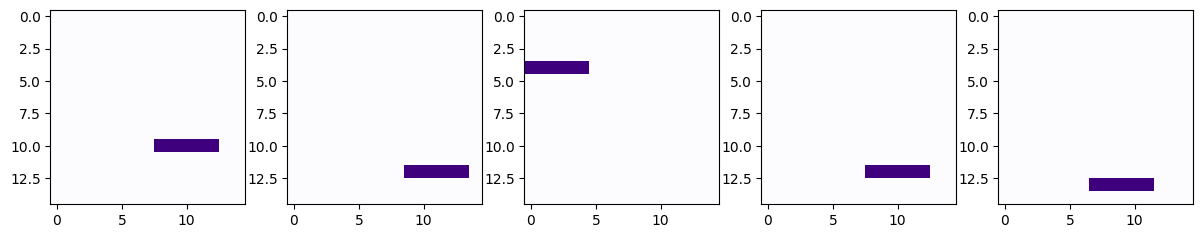

In [6]:
fig, axs = plt.subplots(1, K, figsize=(12, 4))
for i in range(K):
  axs[i].imshow(input_saccades[i].detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()


## Hierarchical network

Purpose of the first step is to make transformations absolutely unlinked from the coordinates. We will be building a hierarchical network that will generalize the concept.

In this configuration we cannot use any output tensors or labels and therefore an error function cannot be used for backpropagation in weight adjustment. 

So, how to make a hierarchical network (not CNN) and group these different representation of lines into one latent feature activated on the last layer?

Adjust weights for each connection using Oja’s rule:
   
$
\Delta w_{ij} = \eta \cdot y_i (x_j - y_i \cdot w_{ij})
$

where:

- $w_{ij}$ is the weight between neuron $j$ in the previous layer and neuron $i$ in the current layer.
- $\eta$ is the learning rate.
- $x_j$ is the activation from the previous layer.
- $y_i$ is the activation of the current neuron after applying the current weights.

Now test this trained network on another type of input

In [7]:
new_input = torch.tensor([
  [1, 1, 1, 1, 1],
  [1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1],
  [1, 1, 1, 1, 1]
], dtype=torch.float)
test_set = create_displaced_tensors(new_input,
                                    K=K,
                                    receptive_field_size=(N, N))

## Hierarchical network with feedback

In [8]:
M = N*N

dim_list = [
    [M, 36],
    [36, 16],
    [16, 8],
    [8, 16],
    [16+M, 36],
    [36+M, M],
]

class HierarchicalWithFeedback2(nn.Module):
    def __init__(self, 
                 dim_list,
                 learning_rate=0.01):
        super(HierarchicalWithFeedback2, self).__init__()

        self.layers = nn.ModuleList([nn.Linear(in_dim, out_dim) for in_dim, out_dim in dim_list])
        self.forward_layers = self.layers[:3]
        self.inverse_layers = self.layers[3:]
        self.eta = learning_rate
        self.tau = 0.4

    def forward(self, x):
        x = x.flatten()
        activations = [x]
        for layer in self.forward_layers:
            x = torch.relu(layer(x))
            activations.append(x)
        return activations
    
    def forward_back(self, x, z):
        # x = activations[0] # original input
        # z = forward_activations[-1] # latent space
        back_activations = [z]
        for i in range(len(self.inverse_layers)):
            layer = self.inverse_layers[i]
            if i > 0:
                z = torch.cat([x, z], dim=0)
            z = layer(z)
            z = torch.relu(z)
            back_activations.append(z)
        return back_activations

    def oja_update(self, activations):
        for i in range(len(activations) - 1):
            layer = self.forward_layers[i]
            weight = layer.weight.data
            
            prev_layer_x = activations[i]
            curr_layer_y = activations[i + 1].unsqueeze(0).T

            weight += self.eta * curr_layer_y * (prev_layer_x - curr_layer_y * weight)
    
    def oja_update_back(self, activations, forward_activations):
        x = forward_activations[0]
        for i in range(len(activations) - 1):
            layer = self.inverse_layers[i]
            weight = layer.weight.data
            
            z = activations[i]
            if i > 0:
                z = torch.cat([x, z], dim=0)
            prev_layer_x = z
            if i + 1 == len(activations) - 1:
                curr_layer_y = (forward_activations[0]).unsqueeze(0).T
            else:
                curr_layer_y = (activations[i + 1]).unsqueeze(0).T
            weight += self.eta * curr_layer_y * (prev_layer_x - curr_layer_y * weight)

In [10]:
model = HierarchicalWithFeedback2(dim_list)

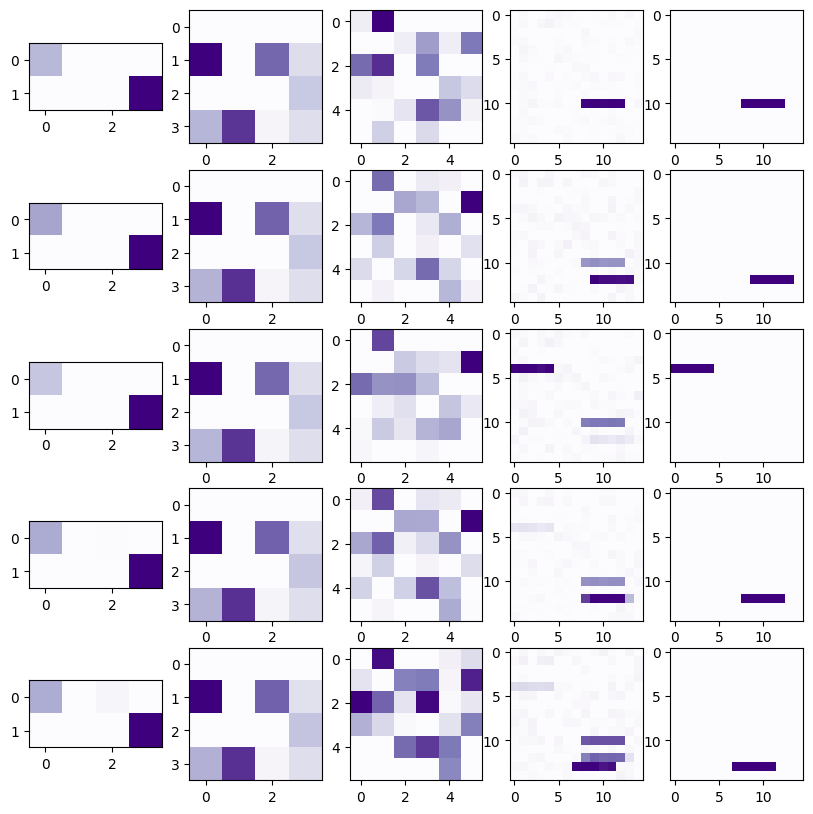

In [12]:
model.eta = 0.5
model.tau = 0.4

fig, axs = plt.subplots(K, 5, figsize=(10, 10))

for i in range(K):
    x = input_saccades[i]
    y = model(x)
    z = model.forward_back(y[0], y[-1])
    model.oja_update_back(z, y)
    zz = model.forward_back(y[0], y[-1])
    
    # error = zz[3] - y[0]
    # latent_repr = y[-1]
    # latent_correction = 1.0 * torch.matmul(error.unsqueeze(0), model.inverse_layers[0].weight)
    
    
    axs[i,0].imshow(zz[0].view(2,-1).detach().numpy(), cmap=cm.Purples)
    axs[i,1].imshow(zz[1].view(4,4).detach().numpy(), cmap=cm.Purples)
    axs[i,2].imshow(zz[2].view(6,6).detach().numpy(), cmap=cm.Purples)
    axs[i,3].imshow(zz[3].view(15,15).detach().numpy(), cmap=cm.Purples)
    axs[i,4].imshow(x.view(15,15).detach().numpy(), cmap=cm.Purples)

plt.show()

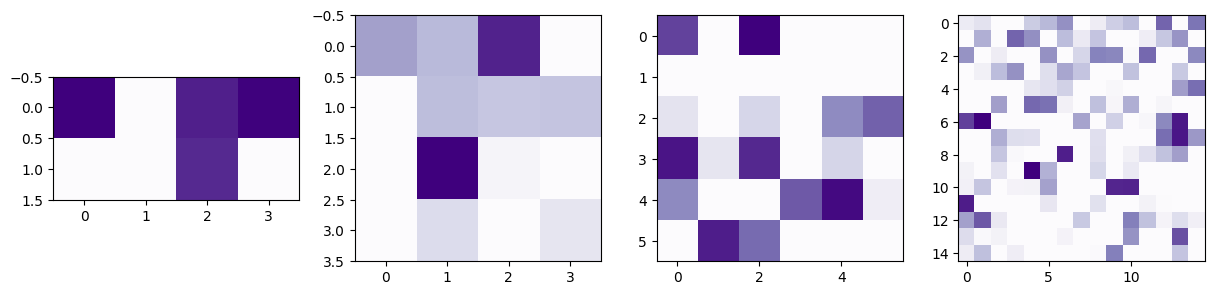

In [27]:
#x_r = per_layer_data[3]
a = model.forward_back(per_layer_data)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(a[0].view(2,-1).detach().numpy(), cmap=cm.Purples)
axs[1].imshow(a[1].view(4,4).detach().numpy(), cmap=cm.Purples)
axs[2].imshow(a[2].view(6,6).detach().numpy(), cmap=cm.Purples)
axs[3].imshow(a[3].view(15,15).detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()

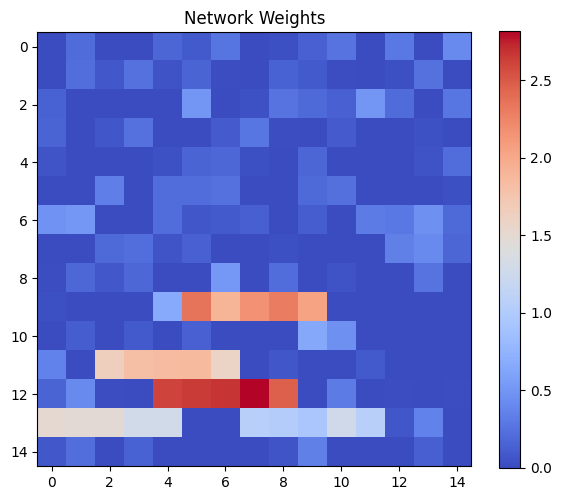

In [33]:
x = aa[3]
x
plt.figure(figsize=(6, 5))
x_mat = plt.imshow(x.view(15,15).detach().numpy(), cmap=cm.coolwarm)
plt.colorbar(x_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.show()

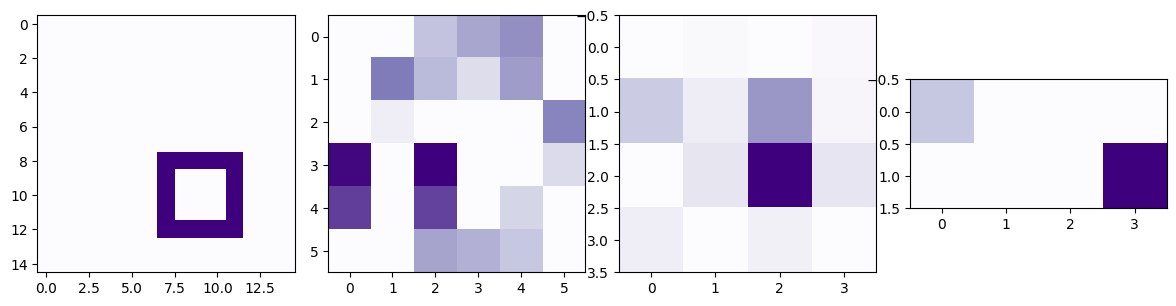

In [13]:
a = test_set[0]
per_layer_data = model(a)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(per_layer_data[0].view(15,15).detach().numpy(), cmap=cm.Purples)
axs[1].imshow(per_layer_data[1].view(6,6).detach().numpy(), cmap=cm.Purples)
axs[2].imshow(per_layer_data[2].view(4,4).detach().numpy(), cmap=cm.Purples)
axs[3].imshow(per_layer_data[3].view(2,-1).detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()

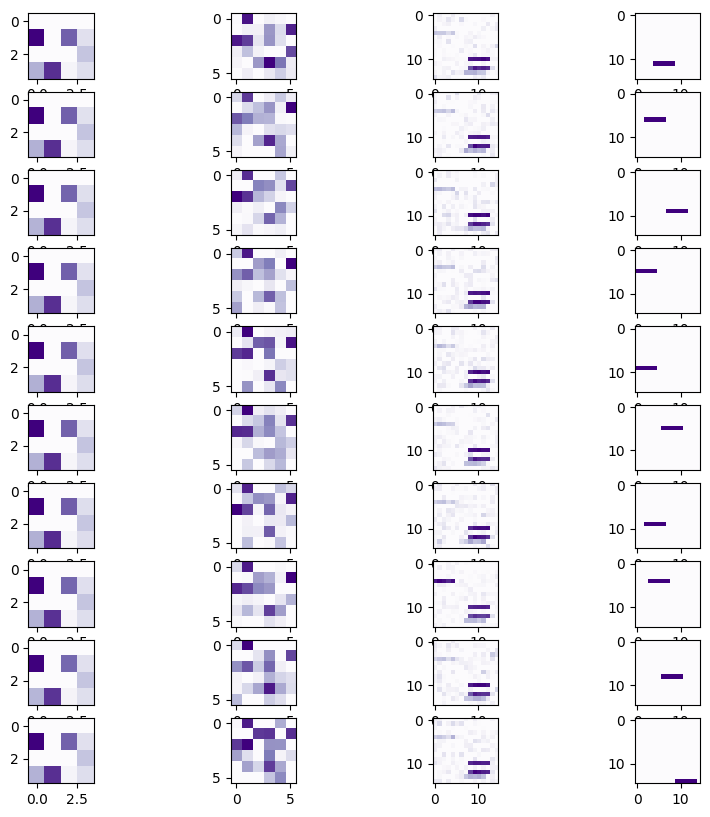

In [14]:
L = 10
test_saccades = create_displaced_tensors(input, K=L, receptive_field_size=(N, N))
fig, axs = plt.subplots(L, 4, figsize=(10, 10))
# x = test_set[0]

for i in range(L):
    x = test_saccades[i]
    # y0 = torch.zeros_like(input_saccades[k]).flatten()
    y = model(x)
    aa = model.forward_back(y[0], y[-1])

    axs[i,0].imshow(aa[1].view(4,4).detach().numpy(), cmap=cm.Purples)
    axs[i,1].imshow(aa[2].view(6,6).detach().numpy(), cmap=cm.Purples)
    axs[i,2].imshow(aa[3].view(15,15).detach().numpy(), cmap=cm.Purples)
    axs[i,3].imshow(y[0].view(15,15).detach().numpy(), cmap=cm.Purples)

plt.show()

(?) Use an unsupervised clustering method, such as k-means or self-organizing maps (SOMs), at the final layer to form clusters in latent space.

In this hierarchical network with Oja's learning, there is nothing that represents connection between neurons on the same layer. 
And we still don't want to go down to CNN kernels because they are not biologically plausible.

We need to choose a method that can save relative positions between important neurons, meaning that these positions play a key role in recognizing an invariant.

In the brain, neurons within the same layer often have lateral (side-to-side) connections that modulate the influence they have on each other.

We can use attention-like matrix that is appplied to the embeddings

In [ ]:
# Apply lateral influence
x = torch.relu(x + torch.matmul(self.lateral_matrices[i], x))

In [107]:
# Define a grid adjacency matrix for lateral connections
def create_adjacency_matrix(size, distance_fn=lambda x, y: 1 / (1 + abs(x - y))):
    adj_matrix = torch.zeros((size, size))
    for i in range(size):
        for j in range(size):
            adj_matrix[i, j] = distance_fn(i, j)
    return adj_matrix

grid_adjacency_matrix = create_adjacency_matrix(32)  # Example for a 32-neuron layer

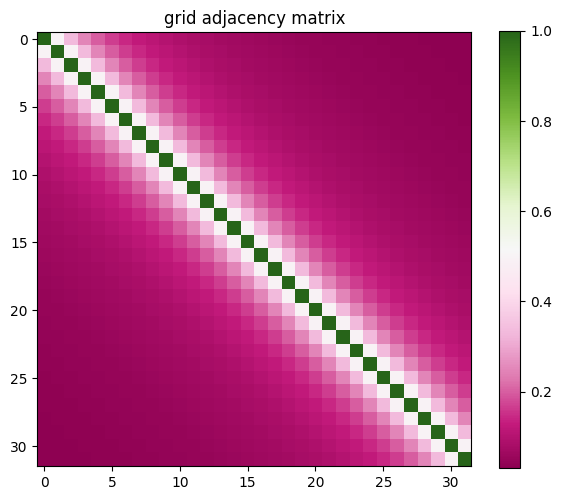

In [116]:
plt.figure(figsize=(6, 5))
w_mat = plt.imshow(grid_adjacency_matrix, cmap=cm.PiYG)
plt.colorbar(w_mat)
plt.title("grid adjacency matrix")
plt.tight_layout()
plt.show()

In Oja’s learning rule, weights tend to reinforce only excitatory (positive) connections because the rule inherently amplifies positive activations and drives down negative values. 
However, in a biologically inspired network, it's important to include both excitatory (positive) and inhibitory (negative) connections

## SOM

In [15]:
class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
    def __init__(self, m, n, dim, alpha=None, sigma=None):
        super(SOM, self).__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.n_neurons = self.m * self.n
        # gain coefficient
        self.alpha = 0.3
        # correction
        self.sigma = max(m, n) / 2.0
        
        if alpha is not None:
            self.alpha = float(alpha)
        if sigma is not None:
            self.sigma = float(sigma)

        self.weights = torch.randn(self.n_neurons, dim)
        self.locations = torch.tensor(np.array(list(self.make_grid_locations_iter(m, n))), dtype=torch.int32)
        self.pdist = nn.PairwiseDistance(p=2)

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def make_grid_locations_iter(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(self.n_neurons)],
                            key=lambda x: np.linalg.norm(vect-self.weights[x]))
            to_return.append(self.locations[min_index])

        return to_return

    def forward(self, x, learning_rate_op):
        dists = self.pdist(x, self.weights) # compare X with every column in W. columns is a batch dimension
        bmu_index = dists.min(0).indices # find the minimum distance
        bmu_loc = self.locations[bmu_index,:]
        
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        diff = self.locations - bmu_loc # .unsqueeze(0).repeat(self.n_neurons, 1) - don't need to copy because broadcasting will do it (ref: https://numpy.org/doc/stable/user/basics.broadcasting.html)
        bmu_distance_squares = torch.sum(torch.pow(diff.float(), 2), 1) # array where for every neuron i: x_i ^2 + y_i ^2 -> d_i
        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2))) # e^{ -(d_i / sigma^2) }
        gain_coefficient = alpha_op * neighbourhood_func
        learning_rate_multiplier = gain_coefficient.repeat(self.dim, 1).T # copy to every dimension
        delta = torch.mul(learning_rate_multiplier, x - self.weights) # (x - self.weights) - uses broadcasting too

        self.weights += delta
    
    def forward_no_training(self, x):
        # find a location where the distance between x and m_i is the minimum 
        min_index = torch.linalg.vector_norm(x - self.weights, ord=2, dim=1).min(0).indices
        return self.locations[min_index]

In [ ]:
batch_size = 100
n_iter = 5
som_dim = N * N
som = SOM(N, N, som_dim)

for iter_no in range(n_iter):
    data = create_displaced_tensors(input, K=batch_size, receptive_field_size=(N, N))
    # data dimension is 225 (15x15)
    for i in range(len(data)):
        learning_rate_op = 1.0 - iter_no/(1.0*n_iter)
        som(data[i], learning_rate_op)